<a href="https://colab.research.google.com/github/ricvolpe/ml-essentials/blob/master/papers/Geneartive_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Essentials: Generative Adversarial Networks
---

Generative Adversarial Networks (GAN) are one, if not the, most interesting innovations in Artificial Intelligence in the last 10 years. Yann LeCun, one of the fathers of back-propagation, the core algorithm behind Deep Neural Networks went as far as saying that they are “the coolest idea in deep learning in the last 20 years.” 

Up until the emergence of GANs, all most impressive results in Artificial Intelligence and Deep Learning were associated with *discriminative* models, that is, models that given a data input can associate a meta-data output to the input, such as identifying an animal type in a picture or the text corresponding to a audio wave. GANs, very differently, are *generative* models, that is, given a noise input, the create something out of this noise.

In this **Machine Learning Essentials** notebook, I share my understandings, notes and reflecltion on replicating the very first GAN developed as describe by, the now cornerstone of machine learning, paper *Generative Adversarial Nets* written by Ian Goodfellow, Yoshua Bengio, Aaron Courville and others in 2014.

## Original Code and CPUs

At first, I tried to fork and replicate the original source code provided with the GAN paper at [this GitHub lik](https://github.com/goodfeli/adversarial). However, the code has been un-maintained for few years and machine learning repositories become legacy extremely quickly these days. The code is largely built on the now un-maintained librarly *PyLearn2* (originally developed by some of the same authors of the paper). After substantial tweaking and re-built of all dependecies in other to find the exact versions of all packages that would enable the code to run, I finally managed it, watching my first local GAN running with some satisfaction.

Only then I remembered that I had no GPU on my local machine. Collecting the training results when my computer was lameting overheating, my low expecetations were confirmed by the visualisation below:

![attempt-at-replicating-results-on-CPU](https://docs.google.com/uc?export=download&id=1-rg06sWwauXKesjcNjYxPM9Y-_GiiifQ)

Intriguide by the details of the paper and unsatisfied with my first replica, I turned to Google Collaborative, which offers Jupyter Notebooks with available GPU and TPU runtimes. However, as I realized that was not worth to perform all the tweaks and library installations to get the un-maintained original code to work on a Colab Notebook, I quickly found more modern [Tensorflow](https://towardsdatascience.com/generative-adversarial-networks-using-tensorflow-c8f4518406df) and [Keras](https://github.com/eriklindernoren/Keras-GAN) re-implementations of GANs.

## Theory, Keras and GPUs 


Before GANs, most work on deep generative models focused on models that provided a parametric specification of a probability distribution function. However, such models, had intractable likelihood functions and required approximations. GANs are also often confused with Adversarial Examples. These are not generative models per se, but only show that network can discriminate differently objects that appears very similar to us, confirming the challenge of modelling multi-dimensional distributions.

In a nutshell, Generative Adversarial Networks are made of two multilayer perceptrons: G the generator and D the discriminator. G captures the data distribution, while D tries to tell apart if something was coming from the original data or was generated by G. GANs have a theoretical unique solution where G replicates perfectly the data distribution and D assigns equal probably of being it from G or from data to any example. Both G and D are trained with back propagation, thus, no approximate inference or Markov chains are necessary. 

Formally, the key elements of a GAN are:

![key-elements](https://docs.google.com/uc?export=download&id=1Gcm7uw5TOmXa1NzOzwjqpxAzk-qnoO7I)

While we familiarise with them, let us also start importing all necessary packages required for our paper replication. As the paper provided samples and results for re-generative the famous MNIST handwritten digit data, we will also load this dataset.

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


The generator model (G) take noise as inputs and generate a new image out of it. The generator has the goal of minimizing the number of times in which the discriminator correctly understand that its output is fake (i.e. being caught). That is, it is induced to reproduce exactly the data distribution. While in the original paper the Generator network uses Maxout layers, these are currently not available in Keras and the model below uses batch normalisation and leaky ReLU instead.

In [0]:
def Generator(latent_dim, out_shape):

    model = Sequential()

    model.add(Dense(1200, input_dim=latent_dim, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(out_shape), activation='tanh'))
    model.add(Reshape(out_shape))
    
    print('Generator Model')
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

The discriminator model D, which is a simpler network, has the goal of outputting 1 for every example drawn from the real data and do not incurring in cost when outputting 1 for an example coming from the generator.

In [0]:
def Discriminator(in_shape):

    model = Sequential()

    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    print('Discriminator Model')
    model.summary()

    inp = Input(shape=in_shape)
    validity = model(inp)

    return Model(inp, validity)

Combining the objective functions of both models, we obtain a minmax game in the form expanded below:

![min-max](https://docs.google.com/uc?export=download&id=1QAxJ_h8_TNIdvJUItrqlrUKTkHhkIOqM)

The authors prove in an elegan way that such game has a global optimum where the Generator network replicates the original distribution of the data. The steps below summarise the proof:

![theoretical-proof](https://docs.google.com/uc?export=download&id=1b7Rb11N3dfG_OSBzsq5J2C14aLP5LKAA)

In practic, the authors define a training algorithm - alike the one coded below - who lead G and D to converge to the above global optimum, which is further proved in paper.

![theoretical-proof](https://docs.google.com/uc?export=download&id=1iwM4WMaaXzKuTWORigGFMs_CfCXQS-Kd)

A very important caveat that the authors make is that in practice, adversarial nets represent a limited family of probability distributions via the function G(z; θ_g), and they optimize the θ parameters rather than probablity distribution itself, so the proofs do not fully apply to them. However, the excellent performance of multilayer perceptrons in practice suggests that they are a reasonable model to use despite their lack of theoretical guarantees.

In [0]:
def train(data, latent_dim, generator, discriminator, combined, epochs, batch_size=128):

    # Rescale -1 to 1
    data = data / 127.5 - 1.
    data = np.expand_dims(data, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ----- Train Discriminator
        # Select a random batch of images
        idx = np.random.randint(0, data.shape[0], batch_size)
        imgs = data[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ----- Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
               (epoch, d_loss[0], 100*d_loss[1], g_loss))

After having defined the training algorithm we can now define a function that queries it for new samples and show them to us in a human comprehensive way, so that we ourselves can assess if the generative model is qualitately performing well.

In [0]:
def sample(latent_dim, generator):
    
    noise = np.random.normal(0, 1, (1, latent_dim))
    gen_img = generator.predict(np.random.normal(0, 1, (1, latent_dim)))

    # Rescale 0 - 1
    gen_img = 0.5 * gen_img + 0.5
    
    # Plot
    plt.imshow(gen_img[0, :,:,0], cmap='copper')
    plt.show()

We are not ready to define all the required paramenters (such as the input and output shapes and the gradient optimiser) compile and run our Keras models.

In [0]:
# Set up dimensions
rows = 28
cols = 28
channels = 1
img_shape = (rows, cols, channels)
latent_dim = 100

In [0]:
# Set up models
optimizer = Adam(0.0002, 0.5)

D = Discriminator(img_shape)
D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

G = Generator(latent_dim, img_shape)
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = G(z)

D.trainable = False # For the combined model we will only train the generator
# The discriminator takes generated images as input and determines validity
validity = D(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
print('Combined Model')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
Discriminator Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
No

Let us now train the model on the MNIST training data. Sadly I experienced issues when running the Collaborative Notebook for longer than 10000 epochs, thus, this was the maximum length I could train this GAN replica for.

In [0]:
# Load the dataset
(X_train, _), (X_test, _) = mnist.load_data()

# Train combined model
train(X_train, 100, G, D, combined, epochs=10000)

We can now generate few samples. We can see that, although the low number of epochs and relative fast training, generated samples resemble original numbers fairly well!

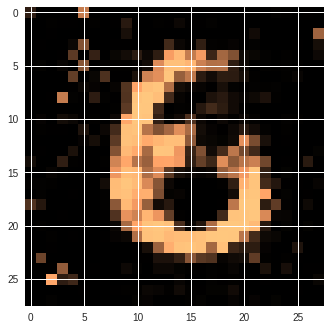

In [0]:
sample(100, G)

## Problematic Bonus: Parzen Window Estimation

To fully replicate the original GAN work, I aimed at reproducing the experimental evaluations provided in the paper as well. The authors evaluate their models using a by fitting a Gaussian Parzen window to the samples generated with G and reporting the log-likelihood of the original data under this distribution. 

The code provided below generates one hundres samples from the trained Generator and then evaluates them using a Gaussian Parzen window. However, for lack of training or perhaps my mistakes in the re-implementation of the window function results are singificantly different from the original ones provided in the paper. As my understanding of machine learning essentials matures, I will further investigate this discrepancy.

In [0]:
samples = np.array([G.predict(np.random.normal(0, 1, (1, 100))) for x in range(len(X_test))])

In [0]:
import time

def parzen(X, sigma):

    def parzen_window(x):
        mu = X
        a = (x.reshape(x.shape[0], 1, x.shape[1]) - mu.reshape(1, mu.shape[0], mu.shape[1])) / sigma
        est = (1 / sigma * np.sqrt(np.pi * 2)) * (np.exp(-0.5*(a**2).sum(2)))
        return est
    return parzen_window

def batch_mean_of_densities(n_batches, pz_win, X, indexes):
    times = []
    nlls = []
    for i in range(n_batches):
        begin = time.time()
        nll = pz_win(X[indexes[i::n_batches]])
        end = time.time()
        nlls.extend(nll)
        times.append(end-begin)

        if i % 10 == 0:
            print (i, np.mean(times), np.mean(nlls))
    return nlls

In [0]:
samples = samples.reshape((samples.shape[0], np.prod(samples.shape[1:])))
pz_win = parzen(samples, 0.5)

In [0]:
X_test_norm = X_test / 127.5 - 1.
X_test_norm = X_test_norm.reshape((X_test_norm.shape[0], np.prod(X_test_norm.shape[1:])))

In [0]:
inds = range(X_test_norm.shape[0])
n_batches = int(np.ceil(float(len(inds)) / 10))
nlls = batch_mean_of_densities(n_batches, pz_win, X_test_norm, inds)

In [0]:
ll = np.array(nlls)
se = ll.std() / np.sqrt(X_test_norm.shape[0])
print(ll.mean(), se)

## References

- https://kaushikghose.wordpress.com/2013/10/23/parzen-windows-for-estimating-distributions/
- https://www.projectrhea.org/rhea/index.php/Parzen_Window_Density_Estimation
- http://www.personal.reading.ac.uk/~sis01xh/teaching/CY2D2/Pattern2.pdf
- https://towardsdatascience.com/generative-adversarial-networks-using-tensorflow-c8f4518406df .
- https://github.com/eriklindernoren/Keras-GAN
